In [1]:
n_fold= 1
total_fold= '5'
use_enchanced_dataset= False
model_name= "SwinTransfrmr"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from tqdm.notebook import tqdm

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import *
from keras.models import Model, Sequential, model_from_json, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from keras import backend as K
#from keras.applications.densenet import DenseNet121

import util
from sklearn.metrics import confusion_matrix, classification_report
from livelossplot import PlotLossesKeras
from keras.initializers import RandomNormal
from swintransformer import SwinTransformer

2022-11-24 19:33:09.673242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 19:33:09.866523: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-24 19:33:10.567010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-24 19:33:10.567112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.set_visible_devices(gpus[2], 'GPU')

print("Test built: {}".format(tf.test.is_built_with_cuda()))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Test built: True


In [4]:
if use_enchanced_dataset == True:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/enchanced/"
else:
    IMAGE_DIR = "/home/cries/Dataset/X-Ray/original/images/"
    
train_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "train_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]
test_df= pd.read_csv("/home/cries/Dataset/X-Ray/DataFrame/" + str(total_fold) + "Fold/" + "test_Fold" + str(n_fold) + ".csv").loc[:,'Image Index':]

labels = ['No Findings',
          'Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

print("Leakage between train and test: {}".format(util.check_for_leakage(train_df, test_df, 'Image Index')))

Leakage between train and test: False


In [5]:
# Setting
seed= 1
batch_size= 32
# target_w= 320; target_h= 320; dim= (3,)
target_w= 224; target_h= 224; dim= (3,)
image_size_target= (target_w,target_h)
image_shape= image_size_target + dim
class_mode= 'raw'   # raw, categorical 

use_aug= False
use_normalize= True
index_col= "Image Index"
labels_col= labels

def prepare_generator(use_Aug, use_Normalize):
    # == Aug Image
    if use_Aug== True and use_Normalize== False:
        return ImageDataGenerator(
            rescale= 1./255,        
            horizontal_flip= True,
            height_shift_range= 0.5,
            width_shift_range= 0.5,
            vertical_flip= True,
            rotation_range= 20,
            fill_mode= "nearest"
            )
    # == Normalize Image
    if use_Aug== False and use_Normalize== True:
        return ImageDataGenerator(
            rescale= 1./255, 
            samplewise_center= True,
            samplewise_std_normalization= True
            )
    # == Without
    if use_Aug== False and use_Normalize== False:
        return ImageDataGenerator()

============ getting train generator ===========
Found 4484 validated image filenames.

==== getting train and test/valid generators ====
Found 4484 validated image filenames.
Found 1122 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


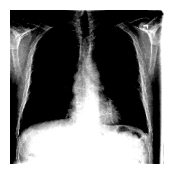

In [6]:
# === Image Train Generator
print("============ getting train generator ===========") 
image_train= prepare_generator(use_Aug=False, use_Normalize=True).flow_from_dataframe(
    dataframe= train_df,
    directory= IMAGE_DIR,
    x_col= index_col,
    y_col= labels,
    class_mode= class_mode,
    batch_size= batch_size,
    shuffle= True,
    target_size= image_size_target
)

# === Image Validation and Test Generator
print("")
print("==== getting train and test/valid generators ====")
raw_train_generator= prepare_generator(False, False).flow_from_dataframe(
                        dataframe= train_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= True,
                        target_size= image_size_target
                    )
batch= raw_train_generator.next()
data_sample= batch[0]
imagegenerator= prepare_generator(False, True)
imagegenerator.fit(data_sample)
image_val = imagegenerator.flow_from_dataframe(
                        dataframe= test_df,
                        directory= IMAGE_DIR,
                        x_col= index_col,
                        y_col= labels,
                        class_mode= class_mode,
                        batch_size= batch_size,
                        shuffle= False,
                        target_size= image_size_target
                    )

x_image, y_image = image_train.__getitem__(0)
plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(x_image[0]);

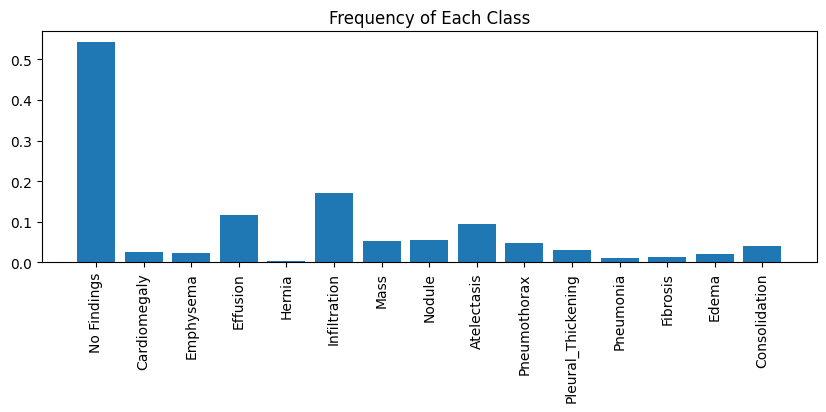

In [7]:
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(image_train.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [8]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies
    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(image_train.labels)
freq_pos

array([0.54192685, 0.02520071, 0.02363961, 0.11641392, 0.00223015,
       0.17105263, 0.05307761, 0.0544157 , 0.0941124 , 0.04772525,
       0.03077609, 0.01137377, 0.01449599, 0.02118644, 0.0396967 ])

/tmp/ipykernel_39064/3905682285.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


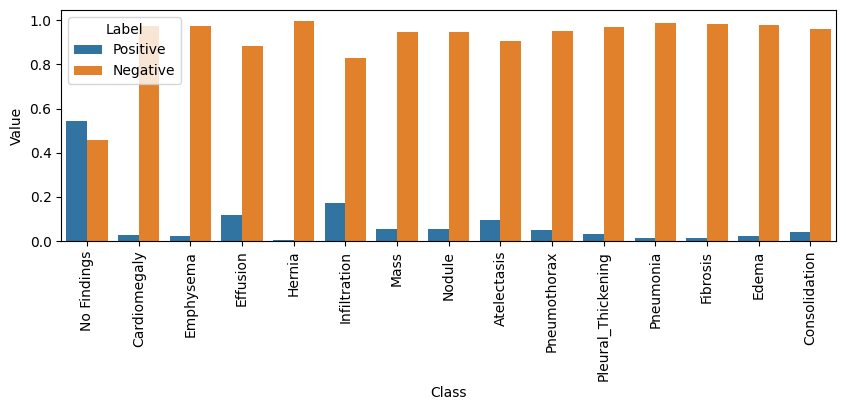

In [9]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

/tmp/ipykernel_39064/1531308047.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


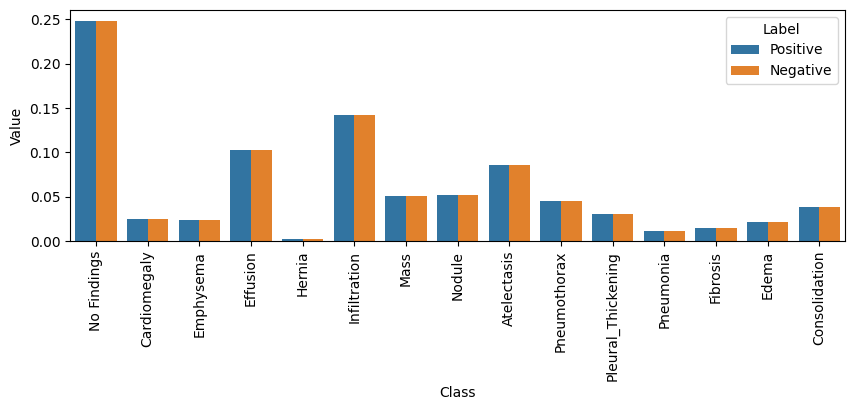

In [10]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.figure(figsize=(10,3))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [11]:
image_shape

(224, 224, 3)

In [12]:
inputs= Input(shape=(224,224,3))
swin = SwinTransformer('swin_tiny_224', include_top=False, pretrained=True)(inputs)
swin_output = Flatten()(swin)

Swin_Model = Model(inputs, swin_output, name="Swin")
Swin_Model.trainable = False

2022-11-24 19:33:13.478404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 19:33:13.964984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7826 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:21:00.0, compute capability: 6.1


In [13]:
MobileNet_V3 = tf.keras.applications.MobileNetV3Small(weights='imagenet', 
                                                      alpha=1.0, 
                                                      include_top=False)(inputs)

outputs = MaxPooling2D(pool_size=(2, 2),padding='same')(MobileNet_V3)
outputs = Flatten()(outputs)
mb3_Model = Model(inputs=inputs, outputs=outputs, name="MobileNet-V3")
mb3_Model.trainable = False

In [14]:
num_class = len(labels)

In [15]:
merged_neck = keras.layers.concatenate([Swin_Model.output, mb3_Model.output])
neck = BatchNormalization()(merged_neck)

dense = Dense(16, activation='LeakyReLU')(neck)
dense = Dense(4)(dense)
dense = Dense(16, activation='LeakyReLU')(dense)

merged_head = keras.layers.concatenate([neck, dense])

head = Dense(32, activation='LeakyReLU')(merged_head)
head = Dense(8)(head)
head = Dense(32, activation='LeakyReLU')(head)

head = Dense(num_class, activation='sigmoid')(head)

model = Model(inputs=inputs, outputs=head)

In [16]:
epoch = 25

lr = 0.001
decay_rate = lr / epoch
momentum = 0.99
adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=decay_rate, beta_2=decay_rate*decay_rate, epsilon=1e-07, amsgrad=False)
sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=False)
checkpoint = ModelCheckpoint("ckp_{}.hdf5".format(model_name), monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

# class_weigths = dict(zip(range(len(neg_weights)), neg_weights))
# weighted_loss = get_weighted_loss(pos_weights, neg_weights)
bfce_ls = tf.losses.BinaryCrossentropy(label_smoothing = 0.0)

metric_auc = tf.keras.metrics.AUC(multi_label=True)

model.compile(loss=bfce_ls, optimizer=sgd, metrics=[metric_auc])

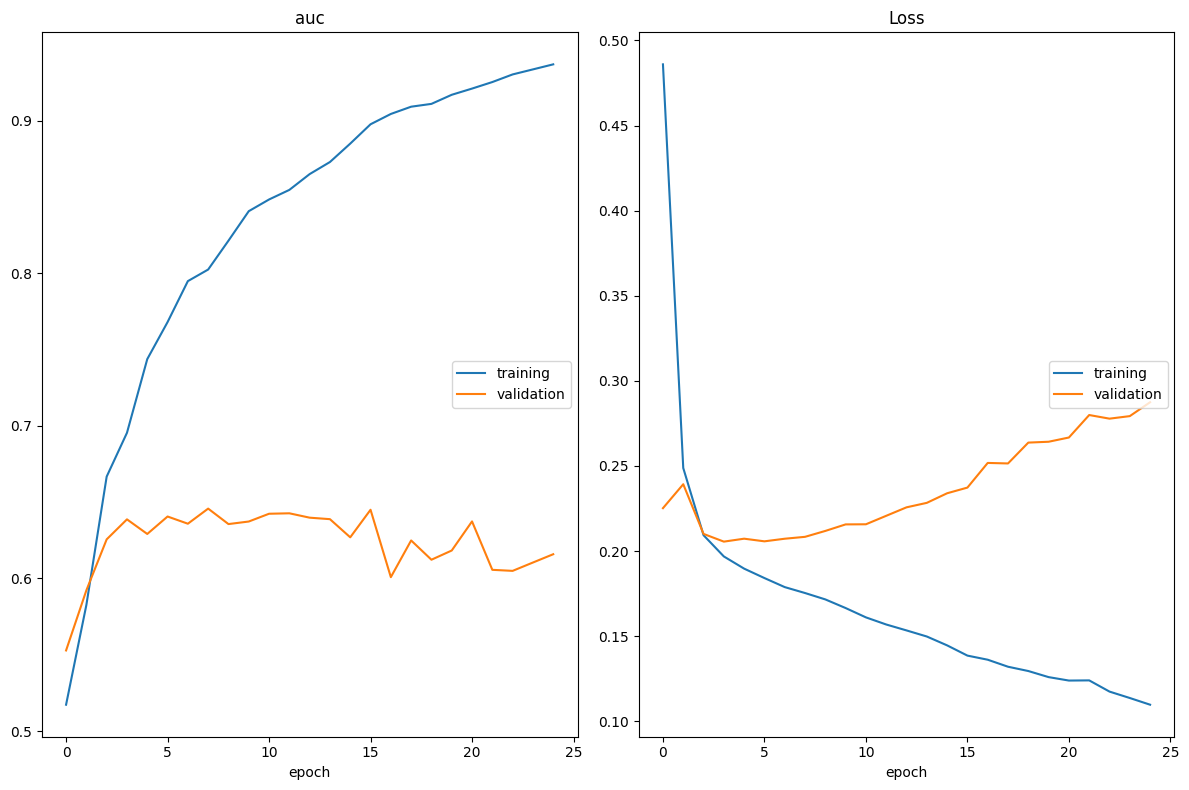

auc
	training         	 (min:    0.517, max:    0.937, cur:    0.937)
	validation       	 (min:    0.553, max:    0.646, cur:    0.616)
Loss
	training         	 (min:    0.110, max:    0.486, cur:    0.110)
	validation       	 (min:    0.206, max:    0.287, cur:    0.287)
141/141 [==============================] - 81s 571ms/step - loss: 0.1098 - auc: 0.9370 - val_loss: 0.2875 - val_auc: 0.6159


In [17]:
start = time.time()
history = model.fit(image_train, epochs=epoch, validation_data=image_val, callbacks=[checkpoint,PlotLossesKeras()],verbose=1)
end_train = time.time() - start

In [18]:
model.save('model_{}'.format(model_name))

INFO:tensorflow:Assets written to: model_SwinTransfrmr/assets


INFO:tensorflow:Assets written to: model_SwinTransfrmr/assets


In [19]:
import os
model.save_weights("{}_weights.h5".format(model_name))
file_stats = os.stat("{}_weights.h5".format(model_name))
model_size = round(file_stats.st_size / (1024 * 1024), 2)
model_parameter = model.count_params()

In [20]:
import pickle

with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [21]:
#Load Model
from tensorflow import keras
model_fusion = keras.models.load_model('./model_{}/'.format(model_name))

In [22]:
predicted_vals = model_fusion.predict_generator(image_val, steps = len(image_val))

/tmp/ipykernel_39064/462794643.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model_fusion.predict_generator(image_val, steps = len(image_val))


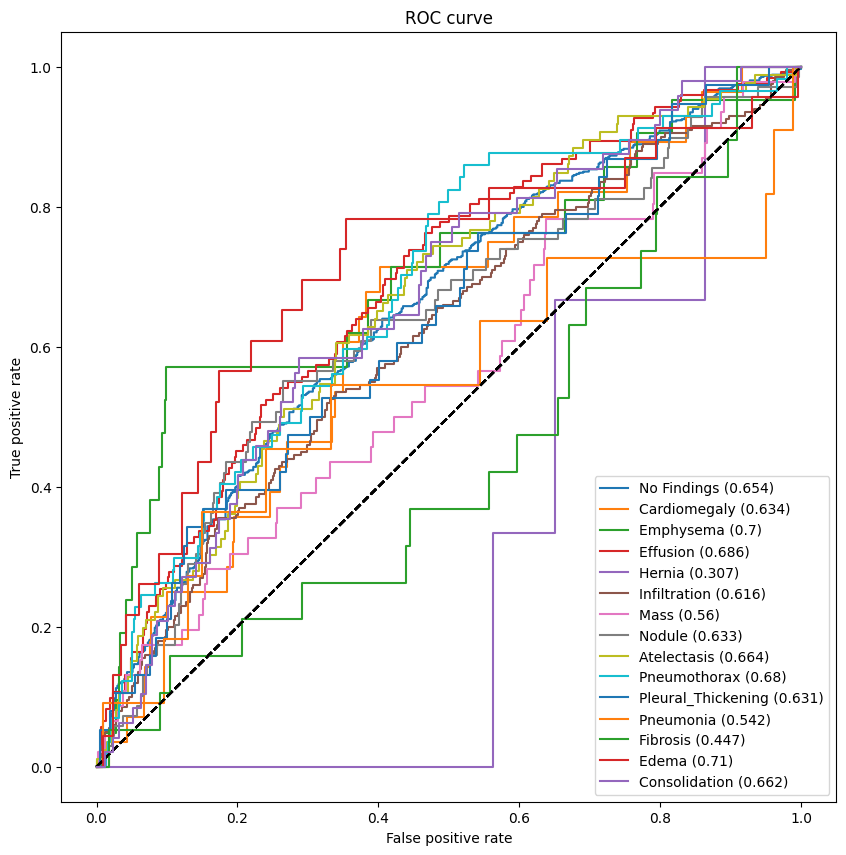

In [23]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, image_val)

In [24]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()
print(device)

<CUDA device 2 'b'NVIDIA GeForce GTX 1080 Ti''>


In [25]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import multilabel_confusion_matrix
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score

# start = time.time()
# y_prob = model_fusion.predict(image_val)
# end_test = time.time() - start

# y_pred = np.argmax(y_prob, axis=1)
# y_true = image_val.classes

# print("Precision:", precision_score(y_true, y_pred, average='weighted'), "Recall:", recall_score(y_true, y_pred, average='weighted'))

# cm = multilabel_confusion_matrix(y_true, y_pred)

# a = []

# for i in range(len(cm)):
#     a.append(cm[i].ravel())

# tp, fn, fp, tn =np.sum(np.array(a), axis = 0)

# print("tp, fn, fp, tn:", tp, fn, fp, tn)

# print("Specificity:", tn / (tn+fp), "Sensitivity:", tp / (tp+fn))
# print("F1-Score:", f1_score(y_true, y_pred, average='weighted'), "Accuracy:", accuracy_score(y_true, y_pred))

# Specificty = tn / (tn+fp)
# Sensitivity = tp / (tp+fn)
# F1_Score = f1_score(y_true, y_pred, average='weighted')
# Accuracy = accuracy_score(y_true, y_pred)

In [ ]:
# result = [y_true, y_pred]
# pd.DataFrame(result).to_csv("{}_{}_result.csv".format(model_name, n_fold))
# pd.DataFrame(y_prob).to_csv("{}_{}_probability.csv".format(model_name, n_fold))

In [ ]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
# m_auc = roc_auc_score(y_true, y_pred)

# print(fpr_keras, tpr_keras, thresholds_keras, m_auc)

# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)
# print(auc_keras)

In [ ]:
# # keep probabilities for the positive outcome only
# lr_probs = y_prob[:, 1]
# lr_auc = roc_auc_score(y_true, lr_probs)
# print('Model Fusion: ROC AUC=%.3f' % (lr_auc))

# lr_fpr, lr_tpr, _ = roc_curve(y_true, lr_probs)

# plt.figure(figsize=(10, 10))
# font={'size':'15'}
# plt.rc('font',**font)

# plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
# plt.plot(lr_fpr, lr_tpr, marker='.', label='{} Model ROC curve (area = %0.2f)'.format(model_name) % lr_auc)

# roc_auc = [lr_fpr, lr_fpr]
# pd.DataFrame(roc_auc).to_csv("{}_roc_auc.csv".format(model_name))

# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()

# AUC_Score = lr_auc

In [ ]:
# Result = [Specificty, Sensitivity, F1_Score, Accuracy, AUC_Score, end_train, end_test, model_size, model_parameter]
# colname = ['Specificty', 'Sensitivity', 'F1_Score', 'Accuracy', 'AUC_Score', 'end_train', 'end_test', 'model_size', 'model_parameter']

# pd.DataFrame([Result], columns=colname).to_csv("{}_fold_".format(model_name)+str(n_fold)+".csv")

# Old Program

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320): 
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
def get_test_generator(test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train generators...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image Index",
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return test_generator

In [ ]:
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image Index", labels)
test_generator= get_test_generator(test_df, train_df, IMAGE_DIR, "Image Index", labels)

In [ ]:
x, y = train_generator.__getitem__(0)
plt.figure(figsize=(5,3))
plt.axis('off')
plt.imshow(x[0]);

In [ ]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [ ]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [ ]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [ ]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [ ]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon))) #complete this line
        return loss

    return weighted_loss

In [ ]:
from keras.applications.densenet import DenseNet121

# create the base pre-trained model
base_model = DenseNet121(weights='/home/cries/.keras/models/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [ ]:
# base_model.summary()

In [ ]:
history = model.fit_generator(train_generator, 
                              #validation_data=valid_generator,
                              #steps_per_epoch=100, # to limit step
                              #validation_steps=25, 
                              epochs = 25)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

### Training on the Larger Dataset 

In [ ]:
# model.load_weights("/home/cries/.keras/models/densenet121_weights_tf_dim_ordering_tf_kernels.h5")

### Prediction and Evaluation

In [ ]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

### ROC Curve and AUROC

In [ ]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
#release memory GPU

from numba import cuda 
device = cuda.get_current_device()
device.reset()
print(device)

### Visualizing Learning with GradCAM

In [ ]:
# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [ ]:
# util.compute_gradcam(model, '00000013_005.png', IMAGE_DIR, train_df, labels, labels_to_show)